In [1]:
import torch
from torch import nn
import torchvision
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import ssl
import seaborn as sns
import time
#import torchbearer

sns.set_theme()
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters
num_epochs = 150
batch_size = 64
learning_rate = 0.01

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


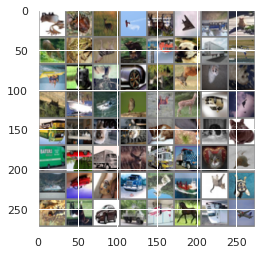

In [4]:
# dataset has PILImage images of range [0, 1].
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip()])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [5]:

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.covModule = nn.Sequential(
            #input a 3x32x32 image
            nn.Conv2d(3, 64, (5,5)),  #image size will be 64x28x28
            nn.ReLU(),
            nn.MaxPool2d((2,2), stride=2),#image size will be 64x14x14
            nn.Conv2d(64, 64, (5,5)), #image size will be 64x10x10
            nn.ReLU(),
            nn.MaxPool2d((2,2), stride=2), #image size will be 64x5x5
            nn.Conv2d(64, 128, (5,5)), #image size will be 64x1x1
            nn.ReLU(),
            #nn.MaxPool2d(2, 2), last maxpool layer cannot work
        )
        self.fcModule = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10),
            #nn.Softmax() #no need for softmax ans CrossEntropy loss already has it
        )
    def forward(self, x):
        x = self.covModule(x)
        x = x.view(-1, 1*1*128)
        output = self.fcModule(x)
        return output

In [6]:
def plotLosses(epochs, Loss, title):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.plot(epochs, Loss, label = "Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

In [7]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, nesterov=True, momentum=0.9)

Epoch [1/150], Step [200/782], Loss: 1.9703, LR:0.01
Epoch [1/150], Step [400/782], Loss: 1.9684, LR:0.01
Epoch [1/150], Step [600/782], Loss: 1.5815, LR:0.01
Epoch [2/150], Step [200/782], Loss: 1.3663, LR:0.01
Epoch [2/150], Step [400/782], Loss: 1.5956, LR:0.01
Epoch [2/150], Step [600/782], Loss: 1.3967, LR:0.01
Epoch [3/150], Step [200/782], Loss: 1.4570, LR:0.01
Epoch [3/150], Step [400/782], Loss: 0.9698, LR:0.01
Epoch [3/150], Step [600/782], Loss: 1.1604, LR:0.01
Epoch [4/150], Step [200/782], Loss: 1.1568, LR:0.01
Epoch [4/150], Step [400/782], Loss: 1.1510, LR:0.01
Epoch [4/150], Step [600/782], Loss: 1.0491, LR:0.01
Epoch [5/150], Step [200/782], Loss: 1.2195, LR:0.01
Epoch [5/150], Step [400/782], Loss: 1.0970, LR:0.01
Epoch [5/150], Step [600/782], Loss: 1.0241, LR:0.01
Epoch [6/150], Step [200/782], Loss: 0.7614, LR:0.01
Epoch [6/150], Step [400/782], Loss: 1.1850, LR:0.01
Epoch [6/150], Step [600/782], Loss: 0.9260, LR:0.01
Epoch [7/150], Step [200/782], Loss: 0.8199, L

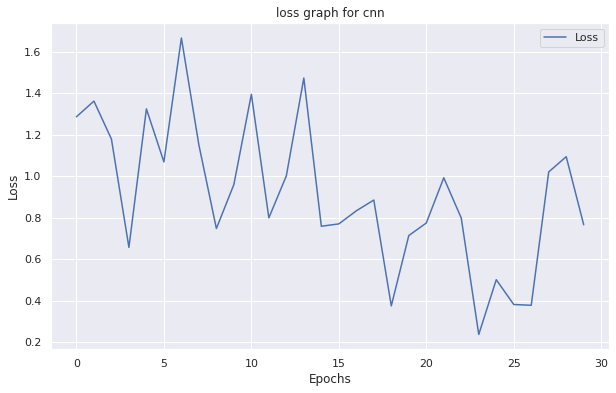

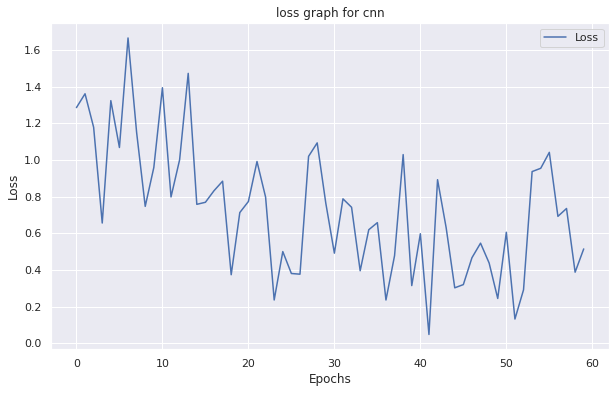

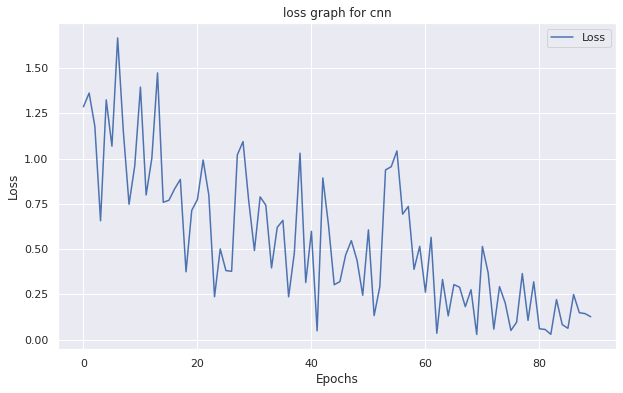

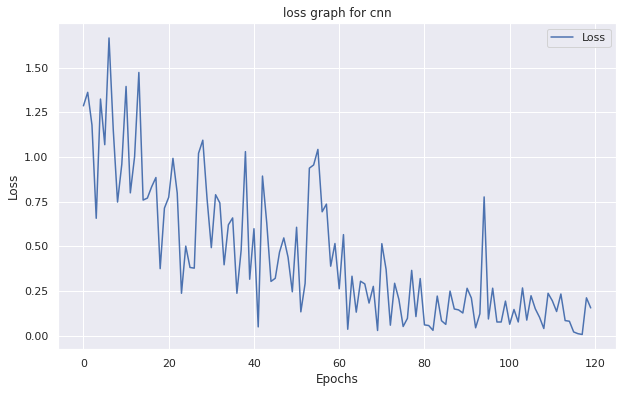

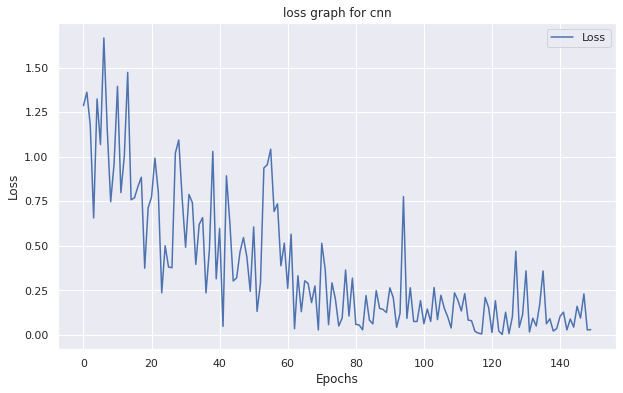

In [8]:
loss_history = []
epochs = []
n_total_steps = len(train_loader)
train_loss = torch.zeros(num_epochs)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60,120], gamma=0.1)
start_time = time.time()
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #get current learning rate
        curr_lr = optimizer.param_groups[0]['lr']

        running_loss += loss.item()
        if (i+1) % 200 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}, LR:{curr_lr}')

    train_loss[epoch] = running_loss
    loss_history.append(loss.item())
    epochs.append(epoch)
    
    #step the learning rate scheduler
    scheduler.step()

    if (epoch+1) % 30 == 0:
        plotLosses(epochs, loss_history, 'loss graph for cnn')
print("--- %s seconds ---" % (time.time() - start_time))

print('Finished Training')
PATH = './cnn-nesterov.pth'
torch.save(model.state_dict(), PATH)

In [9]:

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for label, prediction in zip(labels, predicted):
            if (label == prediction):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')


Accuracy of the network: 74.8 %
Accuracy of plane: 79.0 %
Accuracy of car: 86.3 %
Accuracy of bird: 65.6 %
Accuracy of cat: 53.5 %
Accuracy of deer: 70.8 %
Accuracy of dog: 65.1 %
Accuracy of frog: 80.0 %
Accuracy of horse: 79.1 %
Accuracy of ship: 83.9 %
Accuracy of truck: 84.7 %
